In [ ]:
#Image reconstruction with autoencoder network 
#Improvements to be made:
#Different parameters/hyperparameters to be tested 
#   a) decrease batch size 
#   b) early stopping based on validation loss
#   c) batch normalization
#   d) strides = 1, different number of layers
#   e) increase the latent vector dimension to improve reconstruction

#Next step after the image reconstruction is to denoise 




#Cats and Dogs dataset used from Microsoft (However, I only used the dogs)
#Augmented by flipping image horizontally, vertically, and both 
#Normal set : 10997 train, 1499 test
#Augmented set: 10997*4 train, 1499*4 test

In [1]:
import platform
print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print('Platform System: ' + platform.system())
print(platform.processor())
print(platform.python_compiler())

AMD64
10.0.17763
Windows-10-10.0.17763-SP0
uname_result(system='Windows', node='DESKTOP-MDSP2HJ', release='10', version='10.0.17763', machine='AMD64', processor='Intel64 Family 6 Model 158 Stepping 10, GenuineIntel')
Platform System: Windows
Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
MSC v.1900 64 bit (AMD64)


In [2]:
import sys
import numpy
import matplotlib
import pandas
import keras

Using TensorFlow backend.


In [3]:
print('Python: {}'.format(sys.version))
print('numpy: {}'.format(numpy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pandas.__version__))
print('keras: {}'.format(keras.__version__))

Python: 3.7.1 | packaged by conda-forge | (default, Mar 13 2019, 13:32:59) [MSC v.1900 64 bit (AMD64)]
numpy: 1.16.2
matplotlib: 3.0.3
pandas: 0.24.2
keras: 2.2.4


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import keras
from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import sys

start = time.time();

np.random.seed(42)

In [5]:
import numpy as np

IMG_SIZE = 32

x_train = pickle.load(open("x_train.pickle","rb"))
x_test = pickle.load(open("x_test.pickle", "rb"))
x_train_salt_pepper = pickle.load(open("x_train_salt_pepper.pickle","rb"))
x_test_salt_pepper = pickle.load(open("x_test_salt_pepper.pickle", "rb"))

x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test_salt_pepper = np.array(x_test_salt_pepper).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train_salt_pepper = np.array(x_train_salt_pepper).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_salt_pepper = x_train_salt_pepper.astype('float32') / 255
x_test_salt_pepper = x_test_salt_pepper.astype('float32') / 255

x_train = np.clip(x_train, 0., 1.)
x_test = np.clip(x_test, 0., 1.)
x_train_salt_pepper = np.clip(x_train_salt_pepper, 0., 1.)
x_test_salt_pepper = np.clip(x_test_salt_pepper, 0., 1.)

print(x_train[150].squeeze().max())
print(x_train_salt_pepper[150].squeeze().max())
print(x_test[150].squeeze().max())
print(x_train_salt_pepper[150].squeeze().max())

0.92156863
0.92156863
0.75686276
0.92156863


In [6]:
print(x_train.shape)
print(x_train_salt_pepper.shape)

print(x_test.shape)
print(x_test_salt_pepper.shape)

(10997, 32, 32, 1)
(10997, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)


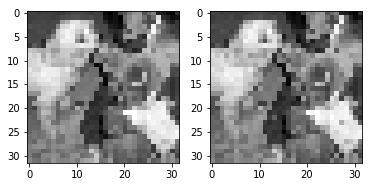

In [7]:
plt.subplot(1,2,1)
plt.imshow(x_train[150].squeeze(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(x_train_salt_pepper[150].squeeze(),cmap="gray")

In [8]:
print(x_test.shape)
print(x_test_salt_pepper.shape)

(1499, 32, 32, 1)
(1499, 32, 32, 1)


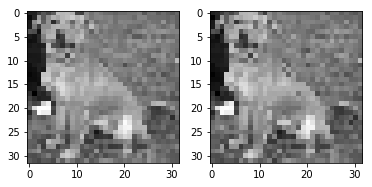

In [9]:
plt.subplot(1,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(x_test_salt_pepper[750].squeeze(),cmap="gray")

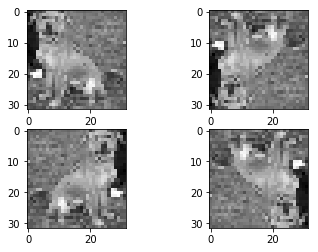

In [10]:
plt.subplot(2,2,1)
plt.imshow(x_test_salt_pepper[750].squeeze(),cmap="gray")
plt.subplot(2,2,2)
plt.imshow(np.flip(x_test_salt_pepper[750],axis=0).squeeze(),cmap="gray")
plt.subplot(2,2,3)
plt.imshow(np.flip(x_test_salt_pepper[750],axis=1).squeeze(),cmap="gray")
plt.subplot(2,2,4)
plt.imshow(np.flip(np.flip(x_test_salt_pepper[750],axis=1),axis=0).squeeze(),cmap="gray")

In [11]:
# x_test2 = np.flipud(x_test)
x_test2 = x_test[...,::-1,:] #flip horiz
x_test3 = x_test[:,::-1,...] #flip vert
x_test4 = x_test3[...,::-1,:] #flip both
x_test = np.append(x_test,x_test2)
x_test = np.append(x_test,x_test3)
x_test = np.append(x_test,x_test4)

x_train2 = x_train[...,::-1,:] #flip horiz
x_train3 = x_train[:,::-1,...] #flip vert
x_train4 = x_train3[...,::-1,:] #flip both
x_train = np.append(x_train,x_train2)
x_train = np.append(x_train,x_train3)
x_train = np.append(x_train,x_train4)

x_train_salt_pepper2 = x_train_salt_pepper[...,::-1,:] #flip horiz
x_train_salt_pepper3 = x_train_salt_pepper[:,::-1,...] #flip vert
x_train_salt_pepper4 = x_train_salt_pepper3[...,::-1,:] #flip both
x_train_salt_pepper = np.append(x_train_salt_pepper,x_train_salt_pepper2)
x_train_salt_pepper = np.append(x_train_salt_pepper,x_train_salt_pepper3)
x_train_salt_pepper = np.append(x_train_salt_pepper,x_train_salt_pepper4)

x_test_salt_pepper2 = x_test_salt_pepper[...,::-1,:] #flip horiz
x_test_salt_pepper3 = x_test_salt_pepper[:,::-1,...] #flip vert
x_test_salt_pepper4 = x_test_salt_pepper3[...,::-1,:] #flip both
x_test_salt_pepper = np.append(x_test_salt_pepper,x_test_salt_pepper2)
x_test_salt_pepper = np.append(x_test_salt_pepper,x_test_salt_pepper3)
x_test_salt_pepper = np.append(x_test_salt_pepper,x_test_salt_pepper4)

In [12]:
print(x_test2.shape)
print(x_test3.shape)
print(x_test4.shape)
print(x_test.shape)

print(x_train2.shape)
print(x_train3.shape)
print(x_train4.shape)
print(x_train.shape)

print(x_test_salt_pepper2.shape)
print(x_test_salt_pepper3.shape)
print(x_test_salt_pepper4.shape)
print(x_test_salt_pepper.shape)

print(x_train_salt_pepper2.shape)
print(x_train_salt_pepper3.shape)
print(x_train_salt_pepper4.shape)
print(x_train_salt_pepper.shape)






(1499, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(6139904,)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(45043712,)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(1499, 32, 32, 1)
(6139904,)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(10997, 32, 32, 1)
(45043712,)


In [13]:
x_test = np.array(x_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train = np.array(x_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_test_salt_pepper = np.array(x_test_salt_pepper).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
x_train_salt_pepper = np.array(x_train_salt_pepper).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print(x_test.shape)
print(x_train.shape)
print(x_test_salt_pepper.shape)
print(x_train_salt_pepper.shape)

(5996, 32, 32, 1)
(43988, 32, 32, 1)
(5996, 32, 32, 1)
(43988, 32, 32, 1)


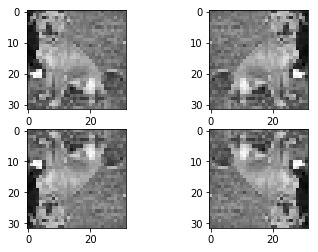

In [14]:
plt.subplot(2,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(2,2,2)
plt.imshow(x_test2[750].squeeze(),cmap="gray")
plt.subplot(2,2,3)
plt.imshow(x_test3[750].squeeze(),cmap="gray")
plt.subplot(2,2,4)
plt.imshow(x_test4[750].squeeze(),cmap="gray")

In [15]:
print(x_test[0].shape)
print(x_train[0].shape)
print(x_test_salt_pepper[0].shape)
print(x_train_salt_pepper[0].shape)

(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


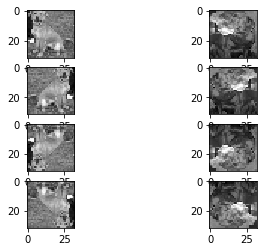

In [16]:
plt.subplot(4,2,1)
plt.imshow(x_test[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test[750+1500*3-2].squeeze(),cmap="gray")

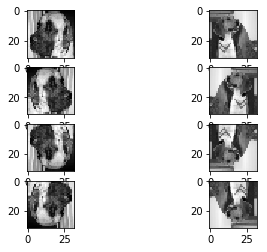

In [17]:
plt.subplot(4,2,1)
plt.imshow(x_train[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train[750+10998*3-2].squeeze(),cmap="gray")

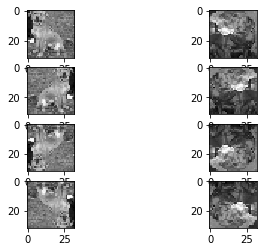

In [18]:
plt.subplot(4,2,1)
plt.imshow(x_test_salt_pepper[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_test_salt_pepper[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_test_salt_pepper[750+1499].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_test_salt_pepper[750+1500].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_test_salt_pepper[750+1499*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_test_salt_pepper[750+1500*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_test_salt_pepper[750+1499*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_test_salt_pepper[750+1500*3-2].squeeze(),cmap="gray")

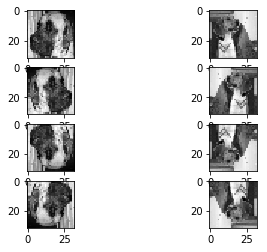

In [19]:
plt.subplot(4,2,1)
plt.imshow(x_train_salt_pepper[750].squeeze(),cmap="gray")
plt.subplot(4,2,2)
plt.imshow(x_train_salt_pepper[751].squeeze(),cmap="gray")
plt.subplot(4,2,3)
plt.imshow(x_train_salt_pepper[750+10997].squeeze(),cmap="gray")
plt.subplot(4,2,4)
plt.imshow(x_train_salt_pepper[750+10998].squeeze(),cmap="gray")
plt.subplot(4,2,5)
plt.imshow(x_train_salt_pepper[750+10997*2].squeeze(),cmap="gray")
plt.subplot(4,2,6)
plt.imshow(x_train_salt_pepper[750+10998*2-1].squeeze(),cmap="gray")
plt.subplot(4,2,7)
plt.imshow(x_train_salt_pepper[750+10997*3].squeeze(),cmap="gray")
plt.subplot(4,2,8)
plt.imshow(x_train_salt_pepper[750+10998*3-2].squeeze(),cmap="gray")

In [26]:
NAME = "autoencoder_salt_pepper-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

image_size = 32
input_shape = (image_size, image_size, 1)
num_epochs = 500
batch_size = 128
kernel_size = 3
latent_dim = 128


#Encoder filters
layer_filters = [96, 64]

#Encoder
#Input using 32x32
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

#Convolution filters
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='tanh',
               padding='same')(x)

shape = K.int_shape(x)

#Latent representation of original image 
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

#Encoder summary 
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

#Decoder filters
layer_filters = [32, 72]

#Decoder
#Using the latent representation as input to decoder 
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

#Deconvolution filters 
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='tanh',
                        padding='same')(x)

x = Conv2DTranspose(filters=1,
                    kernel_size=kernel_size,
                    padding='same')(x)

outputs = Activation('sigmoid', name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

#Using optimizer adadelta for the adaptive learning rate 
autoencoder.compile(metrics = ['mse'],
                    loss='mse', 
                    optimizer='adadelta')

start = time.time();

#Image reconstruction model fit
autoencoder.fit(x_train,
                x_train,
                validation_data= (x_test, x_test),
                epochs=num_epochs,
                batch_size=batch_size)

end = time.time();



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        960       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          55360     
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 128)               524416    
Total params: 580,736
Trainable params: 580,736
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
deco

Epoch 31/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 32/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 33/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 34/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 35/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 36/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0110 - val_mean_squared_

43988/43988 [==============================] - 62s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 128/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 129/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 130/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 131/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 132/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0097 - val_mean_squared_error: 0

43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 224/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 225/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 226/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 227/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 228/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0094 - val_mean_squared_error: 0

43988/43988 [==============================] - 62s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 320/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 321/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 322/500
43988/43988 [==============================] - 64s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 323/500
43988/43988 [==============================] - 63s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0093 - val_mean_squared_error: 0.0093
Epoch 324/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0093 - val_mean_squared_error: 0

43988/43988 [==============================] - 63s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 415/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 416/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 417/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 418/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 419/500
43988/43988 [==============================] - 62s 1ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0092 - val_mean_squared_error: 0

In [27]:
x_decoded = autoencoder.predict(x_test)

In [28]:
#Total training time 
#Laptop: Dell XPS 15 9570
#CPU: i5-8300H
#OS: Windows
#RAM: 8GB
print(start)
print(end)
print(end - start)

1557841181.07456
1557872469.0345623
31287.960002422333


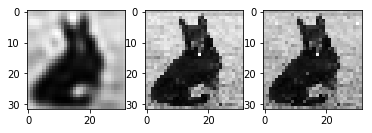

In [29]:
#Example results of image reconstruction from latent vector (32*32)/128
#Decent results but much room for improvement

plt.subplot(1,3,1)
plt.imshow(x_decoded[30].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[30].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_salt_pepper[30].squeeze(),cmap = "gray")


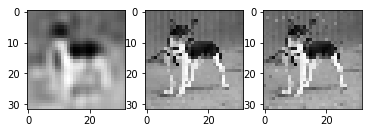

In [30]:
plt.subplot(1,3,1)
plt.imshow(x_decoded[560].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[560].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_salt_pepper[560].squeeze(),cmap = "gray")

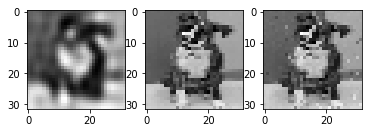

In [31]:
plt.subplot(1,3,1)
plt.imshow(x_decoded[300].squeeze(),cmap = "gray")
plt.subplot(1,3,2)
plt.imshow(x_test[300].squeeze(),cmap = "gray")
plt.subplot(1,3,3)
plt.imshow(x_test_salt_pepper[300].squeeze(),cmap = "gray")

In [32]:
autoencoder.save('autoencoder.h5')
autoencoder.save_weights('autoencoder_weights.h5')

# 